# Assignment 2

### Task:
Implement a multi-layer neural network with:
* linear layer
* Tanh activation
* Instance Normalization
* Softmax + Cross Entropy
* Manual backward pass
* regularization
* SGD optimizer

Train it to classify the spiral dataset

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 0. generate data & utilities

(300, 2) (300,) 0 1


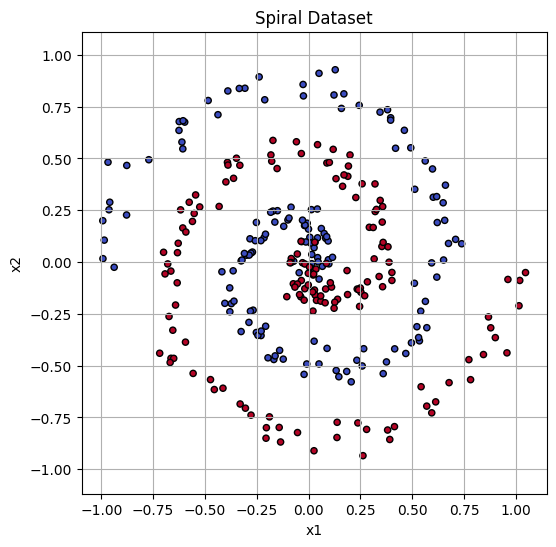

In [2]:


def generate_spiral(n_per_class=200, n_classes=2, noise=0.2, rotations=1.0, seed=0):
    rng = np.random.default_rng(seed)
    N = n_per_class * n_classes
    X = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros((N,), dtype=np.int64)

    # radius grows from 0 to 1
    r = np.linspace(0.0, 1.0, n_per_class, dtype=np.float32)

    for c in range(n_classes):
        # angle: start offset for each class + rotations * 2pi * r
        offset = (2.0 * np.pi / n_classes) * c
        theta = offset + rotations * 2.0 * np.pi * r

        # base spiral
        xs = r * np.cos(theta)
        ys = r * np.sin(theta)

        # add noise
        xs += rng.normal(0.0, noise, size=n_per_class).astype(np.float32)
        ys += rng.normal(0.0, noise, size=n_per_class).astype(np.float32)

        idx0 = c * n_per_class
        idx1 = (c + 1) * n_per_class
        X[idx0:idx1, 0] = xs
        X[idx0:idx1, 1] = ys
        y[idx0:idx1] = c

    return X, y



X, y = generate_spiral(n_per_class=150, n_classes=2, noise=0.05, rotations=1.5, seed=42)
print(X.shape, y.shape, y.min(), y.max())

plt.figure(figsize=(6, 6))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap="coolwarm",
    s=20,
    edgecolors="k"
)

plt.title("Spiral Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid(True)
plt.show()

In [3]:
@torch.no_grad()
def accuracy_from_logits(logits, y):
    pred = torch.argmax(logits, dim=1)
    return (pred == y).float().mean().item()

def plot_spiral(X, y, title="Spiral Dataset"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], s=12, label="Class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=12, label="Class 1")
    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()
@torch.no_grad()
def plot_decision_boundary(model, X, y, title="Decision Boundary", resolution=250):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution),
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    grid_t = torch.tensor(grid, dtype=torch.float32)

    logits = model.forward(grid_t)
    pred = torch.argmax(logits, dim=1).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, pred, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=12, edgecolors="k")
    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.show()
def train_val_split(X, y, val_ratio=0.2, seed=0):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    rng.shuffle(idx)
    n_val = int(len(X) * val_ratio)
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

# classification samples using pytorch API

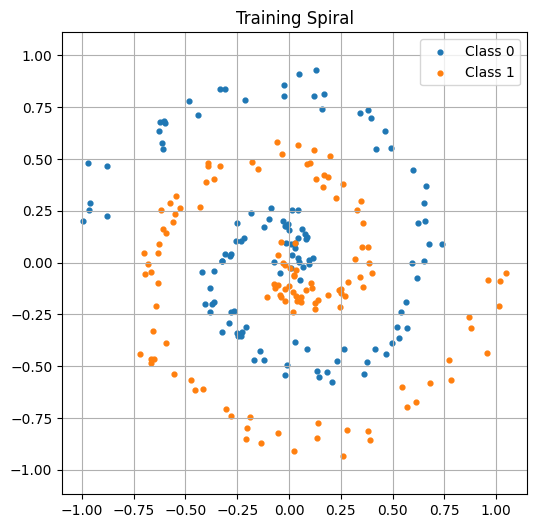

/var/folders/_s/tww7z6ld4bb42wxgx_ss72hc0000gn/T/ipykernel_6591/6013279.py:60: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_loss += float(loss)
/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


Epoch    1 | train loss 0.6790 | train acc 0.578 | val acc 0.517
Epoch  200 | train loss 0.6309 | train acc 0.624 | val acc 0.583
Epoch  400 | train loss 0.6016 | train acc 0.655 | val acc 0.633
Epoch  600 | train loss 0.5272 | train acc 0.723 | val acc 0.717
Epoch  800 | train loss 0.5286 | train acc 0.727 | val acc 0.833
Epoch 1000 | train loss 0.4296 | train acc 0.799 | val acc 0.850
Epoch 1200 | train loss 0.4656 | train acc 0.792 | val acc 0.850
Epoch 1400 | train loss 0.4237 | train acc 0.807 | val acc 0.883
Epoch 1600 | train loss 0.4354 | train acc 0.785 | val acc 0.900
Epoch 1800 | train loss 0.4280 | train acc 0.832 | val acc 0.900
Epoch 2000 | train loss 0.3844 | train acc 0.837 | val acc 0.883


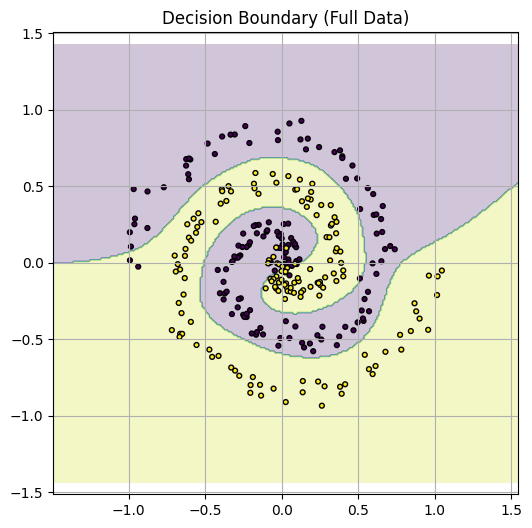

In [4]:
import torch.nn as nn
import torch.optim as optim
X_np, y_np = generate_spiral(n_per_class=150, n_classes=2, noise=0.05, rotations=1.5, seed=42)
Xtr, ytr, Xva, yva = train_val_split(X_np, y_np, val_ratio=0.2, seed=0)

plot_spiral(Xtr, ytr, title="Training Spiral")

# Torch tensors
Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
ytr_t = torch.tensor(ytr, dtype=torch.int64)
Xva_t = torch.tensor(Xva, dtype=torch.float32)
yva_t = torch.tensor(yva, dtype=torch.int64)

# Model (MLP + BN + Tanh)
model = nn.Sequential(
        nn.Linear(2, 64),
        nn.InstanceNorm1d(64),
        nn.Tanh(),
        nn.Dropout(0.2),
        nn.Linear(64, 64),
        nn.InstanceNorm1d(64),
        nn.Tanh(),
        nn.Dropout(0.2),
        nn.Linear(64, 2),)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0)
# opt = SGD(model, lr=0.1, weight_decay=0.0)

# Training hyperparams
epochs = 2000
batch_size = 64
rng = np.random.default_rng(0)

for epoch in range(1, epochs + 1):
    model.train()
    # shuffle
    idx = rng.permutation(len(Xtr_t))
    Xtr_t = Xtr_t[idx]
    ytr_t = ytr_t[idx]

    # mini-batch training
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for start in range(0, len(Xtr_t), batch_size):
        xb = Xtr_t[start:start + batch_size]
        yb = ytr_t[start:start + batch_size]

        opt.zero_grad()

        logits = model.forward(xb)
        loss = loss_fn(logits, yb)

        loss.backward()

        opt.step()

        total_loss += float(loss)
        total_acc += accuracy_from_logits(logits, yb)
        n_batches += 1

    # validation
    model.eval()
    with torch.no_grad():
        val_logits = model.forward(Xva_t)
        val_acc = accuracy_from_logits(val_logits, yva_t)

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | "
                  f"train loss {total_loss / n_batches:.4f} | "
                  f"train acc {total_acc / n_batches:.3f} | "
                  f"val acc {val_acc:.3f}")

# Final plots
plot_decision_boundary(model, X_np, y_np, title="Decision Boundary (Full Data)")